In [1]:
import sys
import pathlib
import numpy as np
import torch
from torch.utils.data import DataLoader
import seaborn as sns
import pickle as pkl

source_dir = (pathlib.Path.cwd()/'..')
sys.path.append(str(source_dir))
import utils
from read_config import Config
import examine_model

In [2]:
config_path = 'configs/model_1000_15.yaml'
config = Config(config_path, root_dir = '../..')

In [3]:
training_set = utils.get_dataset_from_config(config)
training_set = np.array([row[0].numpy() for row in training_set])
latent_means = examine_model.get_saved_latent_space_as_numpy(config)[0]

query_raw = training_set[0]
query_latent = latent_means[0]

protein_length = len(query_raw)//21
size = len(training_set)

In [4]:
single_mutant_library = np.zeros((len(query_raw), len(query_raw)))
for i in range(protein_length):
    for j in range(21):
        base = query_raw.copy()
        base[21*i:21*i+21] = 0
        base[21*i+j] = 1
        single_mutant_library[i*21 + j] = base

In [5]:
model = utils.load_model_from_config(config)

loader = DataLoader(dataset=list(zip(single_mutant_library, [1]*len(single_mutant_library))), batch_size=1)

single_mutant_latents = examine_model.calc_latent_space(model, loader, config.device)
single_mutant_latents = [row[0].numpy() for row in single_mutant_latents]

Loading saved model...


In [6]:
query_distance = np.zeros(len(single_mutant_latents))
origin_distance = np.zeros(len(single_mutant_latents))

query_latent # just here as a reminder
origin = np.zeros(15)

for i in range(len(single_mutant_latents)):
    single_mutant = single_mutant_latents[i]
    query_distance[i] = np.linalg.norm(query_latent-single_mutant)
    origin_distance[i] = np.linalg.norm(origin-single_mutant)

[Text(0, 0.5, 'origin distance'),
 Text(0.5, 0, 'query distance'),
 Text(0.5, 1.0, 'single-mutation latent distances')]

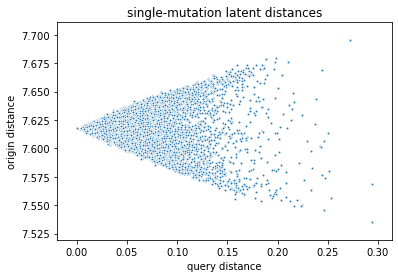

In [7]:
sns.scatterplot(query_distance, origin_distance, marker='.', s=30).set(
    xlabel = 'query distance', ylabel = 'origin distance', title='single-mutation latent distances')

In [8]:
from dataloader import AAs_string
from Bio.SeqUtils import seq3

query_tensor = torch.Tensor(query_raw.reshape(1, -1, 21))
query_string = utils.one_hots_to_proteins(query_tensor)[0]

In [23]:
seqs = 5
o_dist_sorted = sorted(enumerate(origin_distance), key=lambda dist: dist[1])

def analyze_points(points):
    positions = []
    mutations = []
    distances = []
    for row in points:
        i = row[0]
        position = i//21
        old_prot = seq3(query_string[position])
        new_prot = seq3(AAs_string[i%21])
        mutation = '%s->%s'%(old_prot, new_prot)
        distance = origin_distance[i]
        
        positions.append(position)
        mutations.append(mutation)
        distances.append(distance)
    
    return (positions, mutations, distances)

o_far = o_dist_sorted[-seqs:]
o_far.reverse()
o_far_pos, o_far_mut, o_far_dist = analyze_points(o_far)

o_close = o_dist_sorted[:seqs]
o_close_pos, o_close_mut, o_close_dist = analyze_points(o_close)


q_dist_sorted = sorted(enumerate(query_distance), key=lambda dist: dist[1])
# removes identical sequences
start = 0
while q_dist_sorted[start][1] - q_dist_sorted[0][1]==0:
    start+=1
q_close = q_dist_sorted[start:start+seqs]
q_close_pos, q_close_mut, q_close_dist = analyze_points(q_close)

In [36]:
# reminders
o_close_pos, o_far_pos, q_close_pos

ss = np.array(pkl.load(open('training_set_structure.pkl', 'rb'))['ss'])
o_close_ss = ss[o_close_pos]
o_far_ss = ss[o_far_pos]
q_close_ss = ss[q_close_pos]


print('furthest mutations from origin:', *zip(o_far_pos, o_far_mut, o_far_dist, o_far_ss), sep='\n')
print('\nclosest mutations from origin:', *zip(o_close_pos, o_close_mut, o_close_dist, o_close_ss), sep='\n')
print('\nclosest mutations from query:', *zip(q_close_pos, q_close_mut, q_close_dist, q_close_ss), sep='\n')
print('\nprotein length: %d '%protein_length)

# print('\nsecondary structure:', *zip(range(protein_length), ss), sep='\n')

furthest mutations from origin:
(114, 'Gly->Val', 7.695230225104712, '?')
(229, 'Thr->Trp', 7.679757583457256, '?')
(229, 'Thr->Gly', 7.678972343787524, '?')
(14, 'Thr->His', 7.675868091172412, 'h')
(261, 'Val->Asn', 7.675797109765919, '?')

closest mutations from origin:
(93, 'Gly->Cys', 7.535165166247986, '-')
(1, 'Ala->Arg', 7.546125600239124, '?')
(188, 'Asp->Lys', 7.5489589062247315, '?')
(102, 'Thr->Leu', 7.549391956087625, '-')
(116, 'Val->Met', 7.550012362856261, '?')

closest mutations from query:
(241, 'Xaa->Trp', 7.617098580110115, '.')
(361, 'Xaa->Ala', 7.616752466019509, '.')
(423, 'Xaa->Thr', 7.6178877849644335, '.')
(124, 'Val->Gln', 7.619238449067328, '?')
(124, 'Val->Arg', 7.6192936326237, '?')

protein length: 589 
